# Financial Fraud Detection

- The objective of this notebook is to showcase the usage of the [___financial-fraud-training___ container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/cugraph/containers/financial-fraud-training) and how to deploy the produced trained models on [NVIDIA Dynamo-Triton](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver).
- We use [IBM TabFormer](https://github.com/IBM/TabFormer) as an example dataset and the dataset is preprocess before model training

NOTE:
* The preprocessing code is written specifically for the TabFormer dataset and will not work with other datasets.
* Additionally, a familiarity with [Jupyter](https://docs.jupyter.org/en/latest/what_is_jupyter.html) is assumed.

# Environment Setup
This Notebook is designed to work in Sageamaker Studio's Jupyter Lab environment

Please create a Conda environment and add that to the notebook - See the [README](../README.md) file

-----
## Import libraries (both environments)

In [100]:
import os
import sys
import json
import time
import boto3

----
# Step 1: Get and Prepare the data

## For Local
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. untar and uncompreess the file: `tar -xvzf ./transactions.tgz`
3. Put card_transaction.v1.csv in in the `data/TabFormer/raw` folder


In [101]:
# verify that the compressed file was uploaded successfully - the size should be 266M
!ls -lh ../data/TabFormer/raw

total 2.5G
-rw-r--r-- 1 sagemaker-user users 2.2G Oct 28  2020 card_transaction.v1.csv
-rw-r--r-- 1 sagemaker-user users  112 Jul 18 15:25 readme.md
-rw-r--r-- 1 sagemaker-user users 266M Jul 21 14:07 transactions.tgz


In [102]:
# Uncompress/untar the file
!tar xvzf ../data/TabFormer/raw/transactions.tgz -C ../data/TabFormer/raw/

card_transaction.v1.csv


__If__ drag-and-drop is not working, please run the [Download TabFormer](./extra/download-tabformer.ipynb) notebook is the "extra" folder 

## Check data folder structure
The goal is to produce the following structure

```
.
    data
    └── TabFormer
        └── raw
            └── card_transaction.v1.csv
```

In [103]:
# Once the raw data is placed as described above, set the path to the TabFormer directory

# Change this path to point to TabFormer data
data_root_dir = os.path.abspath('../data/TabFormer/') 

# Change this path to the directory where you want to save your model
model_output_dir = os.path.join(data_root_dir, 'trained_models')

# Path to save the trained model
os.makedirs(model_output_dir, exist_ok=True)

### Define python function to print directory tree

In [104]:
def print_tree(directory, prefix=""):
    """Recursively prints the directory tree starting at 'directory'."""
    # Retrieve a sorted list of entries in the directory
    entries = sorted(os.listdir(directory))
    entries_count = len(entries)
    
    for index, entry in enumerate(entries):
        path = os.path.join(directory, entry)
        # Determine the branch connector
        if index == entries_count - 1:
            connector = "└── "
            extension = "    "
        else:
            connector = "├── "
            extension = "│   "
        
        print(prefix + connector + entry)
        
        # If the entry is a directory, recursively print its contents
        if os.path.isdir(path):
            print_tree(path, prefix + extension)

In [105]:
# Check if the raw data has been placed properly
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   └── node_to_node.csv
│   ├── nodes
│   │   ├── node.csv
│   │   ├── node_label.csv
│   │   └── offset_range_of_training_node.json
│   └── test_gnn
│       ├── edges
│       │   └── node_to_node.csv
│       └── nodes
│           ├── node.csv
│           └── node_label.csv
├── raw
│   ├── card_transaction.v1.csv
│   ├── readme.md
│   └── transactions.tgz
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


---
# Step 2: Preprocess the data 
- Import the Python function for preprocessing the TabFormer data
- Call `preprocess_TabFormer` function to prepare the data

NOTE: The preprocessing can takes a few minutes


In [106]:
# Add the "src" directory to the search path
src_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'src'))
sys.path.insert(0, src_dir)

# should be able to import from "src" folder now
from preprocess_TabFormer import preprocess_data

In [107]:
# Preprocess the data
mask_mapping, feature_mask = preprocess_data(data_root_dir)

# this will output status as it correlates different attributes with target column

Correlation (Card, Fraud) =   6.59%
Correlation (Chip, Fraud) =   5.63%
Correlation (Errors, Fraud) =   1.81%
Correlation (State, Fraud) =  35.92%
Correlation (City, Fraud) =  32.47%
Correlation (Zip, Fraud) =  14.99%
Correlation (MCC, Fraud) =  12.70%
Correlation (Merchant, Fraud) =  34.88%
Correlation (User, Fraud) =   3.40%
Correlation (Day, Fraud) =   0.26%
Correlation (Month, Fraud) =   0.23%
Correlation (Year, Fraud) =   2.35%
r_pb (Time) = -0.00 with p_value 0.00
r_pb (Amount) = 0.03 with p_value 0.00
Transaction ID range (0, 301523)
Merchant ID range (0, 42941)
User ID range (0, 4872)
Transaction ID range (0, 25802)
Merchant ID range (0, 6772)
User ID range (0, 4794)


In [108]:
# You should not see files under a "gnn" folder and under a "xgb" folder
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   └── node_to_node.csv
│   ├── nodes
│   │   ├── node.csv
│   │   ├── node_label.csv
│   │   └── offset_range_of_training_node.json
│   └── test_gnn
│       ├── edges
│       │   └── node_to_node.csv
│       └── nodes
│           ├── node.csv
│           └── node_label.csv
├── raw
│   ├── card_transaction.v1.csv
│   ├── readme.md
│   └── transactions.tgz
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


In [109]:
# copy data to S3 to get pulled during training
! aws s3 sync "../data/TabFormer/" s3://ml-on-containers/data/ --exclude "*/test_gnn" --force --delete

upload: ../data/TabFormer/gnn/nodes/offset_range_of_training_node.json to s3://ml-on-containers/data/gnn/nodes/offset_range_of_training_node.json
upload: ../data/TabFormer/gnn/nodes/node_label.csv to s3://ml-on-containers/data/gnn/nodes/node_label.csv
upload: ../data/TabFormer/gnn/edges/node_to_node.csv to s3://ml-on-containers/data/gnn/edges/node_to_node.csv
upload: ../data/TabFormer/gnn/test_gnn/edges/node_to_node.csv to s3://ml-on-containers/data/gnn/test_gnn/edges/node_to_node.csv
upload: ../data/TabFormer/gnn/test_gnn/nodes/node_label.csv to s3://ml-on-containers/data/gnn/test_gnn/nodes/node_label.csv
upload: ../data/TabFormer/xgb/test.csv to s3://ml-on-containers/data/xgb/test.csv
upload: ../data/TabFormer/gnn/nodes/node.csv to s3://ml-on-containers/data/gnn/nodes/node.csv
upload: ../data/TabFormer/xgb/validation.csv to s3://ml-on-containers/data/xgb/validation.csv
upload: ../data/TabFormer/gnn/test_gnn/nodes/node.csv to s3://ml-on-containers/data/gnn/test_gnn/nodes/node.csv
uplo

-----
# Step 3:  Now train the model using the financial-fraud-training container


## Create training configuration file
NOTE: Training configuration file must conform to schema defined [here](https://docs.nvidia.com/nim/financial-fraud-training/latest/configuration/config-json.html)

#### TODO: Put information about how Sagemaker training imports data from S3

In [110]:
sagamaker_config = {
    "paths": {
        "data_dir": "/opt/ml/input/data/data",
        "output_dir": "/opt/ml/model"
    },
    "models": [
    {
      "kind": "GraphSAGE_XGBoost",
      "gpu": "single",
      "hyperparameters": {
        "gnn":{
          "hidden_channels": 16,
          "n_hops": 1,
          "dropout_prob": 0.1,
          "batch_size": 1024,
          "fan_out": 16,
          "num_epochs": 16
        },
        "xgb": {
          "max_depth": 6,
          "learning_rate": 0.2,
          "num_parallel_tree": 3,
          "num_boost_round": 512,
          "gamma": 0.0
        }

      }
    }
  ]
}

#### Save the training configuration as a json file

In [111]:
training_config_file_name = 'sagemaker_config.json'

with open(os.path.join(training_config_file_name), 'w') as json_file:
    json.dump(sagamaker_config, json_file, indent=4)

# clone config to S3
! aws s3 cp ./sagemaker_config.json s3://ml-on-containers/config/training_config.json

upload: ./sagemaker_config.json to s3://ml-on-containers/config/training_config.json


In [112]:
# TODO: Explain the Sageamker create training job API call here

In [113]:
# run the training in Sagemaker
# define training job
training_job_name = "new-nim-" + str(int(time.time()))

# send training job to parameter store
ssm_client = boto3.client("ssm")

ssm_client.put_parameter(Name="/triton/model", Value=training_job_name, Overwrite=True) 

sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.create_training_job(
    TrainingJobName=training_job_name,
    RoleArn="arn:aws:iam::771830474512:role/service-role/AmazonSageMaker-ExecutionRole-20250314T121895",
    AlgorithmSpecification={
        'TrainingImage': "771830474512.dkr.ecr.us-east-1.amazonaws.com/ml/ml-on-gpu:latest",
        'TrainingInputMode': 'File',
        'ContainerEntrypoint': [
            'python',
            'main.py',
            '--config',
            "/opt/ml/input/data/config/training_config.json"
        ]
    },
    InputDataConfig=[
        {
            'ChannelName': 'data',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': 's3://ml-on-containers/data/gnn/',
                    'S3DataDistributionType': 'FullyReplicated'
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        },
        {
            'ChannelName': 'config',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': 's3://ml-on-containers/config/',
                    'S3DataDistributionType': 'FullyReplicated',
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        }
    ],
    OutputDataConfig={
        'S3OutputPath': 's3://ml-on-containers/output/'
    },
    ResourceConfig={
        'InstanceType': 'ml.g4dn.2xlarge',
        'InstanceCount': 1,
        'VolumeSizeInGB': 30
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 86400
    }
)

In [114]:
from IPython.display import clear_output
def poll_training_status(job_name):
    sagemaker_client = boto3.client('sagemaker')
    
    while True:
        response = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        status = response['TrainingJobStatus']
        
        # Clear previous output
        clear_output(wait=True)
        
        # Print current status with timestamp
        print(f"Job: {job_name}")
        print(f"Status: {status}")
        print(f"Last checked: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        
        if status in ['Completed', 'Failed', 'Stopped']:
            break
            
        # Wait before next check
        time.sleep(30)
    
    return status

In [115]:
final_status = poll_training_status(training_job_name)

Job: new-nim-1753210753
Status: Completed
Last checked: 2025-07-22 19:06:49


In [116]:
gnn_data_dir = os.path.join(data_root_dir, "gnn")

---

# Step 3: Launch the model in ECS

----
# Step 4:  Serve your python backend model using NVIDIA Dynamo-Triton

#### Install NVIDIA Dynamo-Triton Client

In [118]:
!pip install 'tritonclient[all]'


In [119]:
import tritonclient.grpc as triton_grpc
import tritonclient.http as httpclient
from tritonclient import utils as triton_utils


##### Replace HOST with the actual URL where your NVIDIA Dynamo-Triton server is hosted.


In [120]:
HTTP_PORT = 8005
GRPC_PORT = 8006
METRICS_PORT = 8007
HOST = 'ec2-3-94-169-253.compute-1.amazonaws.com'

### URLs for GRPC and HTTP request to the inference server

In [121]:
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
client_http = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

## Prediction without computing Shapley values

### Read preprocessed input transactions to send query to NVIDIA Dynamo-Triton

In [122]:
import os
import pandas as pd
import numpy as np

model_name = "prediction_and_shapley"
test_X_path = os.path.join(gnn_data_dir, "test_gnn", "nodes/node.csv") # already preprocessed data
test_X = pd.read_csv(test_X_path)
X = test_X.values.astype(np.float32)

test_y_path = os.path.join(gnn_data_dir, "test_gnn", "nodes/node_label.csv") # already preprocessed data
test_y = pd.read_csv(test_y_path)
y = test_y.values.astype(np.float32)

test_ei_path = os.path.join(gnn_data_dir, "test_gnn", "edges/node_to_node.csv") 
test_ei = pd.read_csv(test_ei_path)


In [123]:
edge_index = test_ei.values.T.astype(np.int64)
compute_shap = np.array([False], dtype=bool) 


### Evaluate performance for a batch of transactions

In [124]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [125]:
# Decision threshold to flag a transaction as fraud
#Change to trade-off precision and recall
decision_threshold = 0.5

In [126]:

def compute_score_for_batch(edge_idx, X, y, batch_size, decision_threshold = 0.5, shap=False, feature_mask=None):
    edge_index = edge_idx.T.astype(np.int64)
    compute_shap = np.array([shap], dtype=bool) # Skip Shapley value computation
    
    with httpclient.InferenceServerClient(f"{HOST}:{HTTP_PORT}") as client:
        input_features = httpclient.InferInput("NODE_FEATURES", X.shape, datatype="FP32")
        input_features.set_data_from_numpy(X)

        input_edge_indices = httpclient.InferInput("EDGE_INDEX", edge_index.shape, datatype="INT64")
        input_edge_indices.set_data_from_numpy(edge_index)

        # Even though Shapley values are not requested, it still requires a feature mask.
        # It can be a dummy array of int values, but the length must be same as number of features.

        if shap:
            assert X.shape[1] == len(feature_mask)
            feature_mask = np.array(feature_mask).astype(np.int32)
        else:
            feature_mask = np.zeros(X.shape[1]).astype(np.int32)

        input_feature_mask = httpclient.InferInput("FEATURE_MASK", feature_mask.shape, datatype="INT32")
        input_feature_mask.set_data_from_numpy(feature_mask)

        compute_shap_flag = httpclient.InferInput("COMPUTE_SHAP", compute_shap.shape, datatype="BOOL")
        compute_shap_flag.set_data_from_numpy(compute_shap)
        
        outputs = [
            httpclient.InferRequestedOutput("PREDICTION"),
            httpclient.InferRequestedOutput("SHAP_VALUES")
        ]

        # Send query to the server
        response = client.infer(
            model_name,
            inputs=[input_features, input_edge_indices, compute_shap_flag, input_feature_mask],
            request_id=str(1),
            outputs=outputs,
            timeout= 3000
            )
        
    predictions = response.as_numpy('PREDICTION')

    assert y.sum() == y[-batch_size:].sum()
    if shap == False:
        y_pred = (predictions > decision_threshold).astype(int)
        
        # Compute evaluation metrics
        accuracy = accuracy_score(y[-batch_size:], y_pred[-batch_size:])
        precision = precision_score(y[-batch_size:], y_pred[-batch_size:], zero_division=0)
        recall = recall_score(y[-batch_size:], y_pred[-batch_size:], zero_division=0)
        f1 = f1_score(y[-batch_size:], y_pred[-batch_size:], zero_division=0)



        classes = ['Non-Fraud', 'Fraud']
        columns = pd.MultiIndex.from_product([["Predicted"], classes])
        index = pd.MultiIndex.from_product([["Actual"], classes])

        conf_mat = confusion_matrix(y[-batch_size:], y_pred[-batch_size:])
        cm_df = pd.DataFrame(conf_mat, index=index, columns=columns)
        print(cm_df)

        # Plot the confusion matrix directly from predictions
        disp = ConfusionMatrixDisplay.from_predictions(
            y[-batch_size:], y_pred[-batch_size:], display_labels=classes)
        disp.ax_.set_title('Confusion Matrix')
        plt.show()

        print("----Summary---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return predictions, response.as_numpy('SHAP_VALUES') if shap else None


#### Sample a batch of transactions from the test data

In [127]:
# NOTE:
# In the preprocessing code, zero-based user node indices come first, 
# followed by merchant node indices, and then transaction node indices.

# Each transaction is represented by four edges,
    # user to transaction,
    # transaction to merchant,
    # transaction to user
    # merchant to transaction

# Each transaction involves three nodes - an user, a transaction and a merchant


NR_TX =  test_ei.shape[0]//4
batch_size = NR_TX

transaction_batch = np.random.choice(NR_TX, size=batch_size, replace=False)
idx_of_edges = transaction_batch.reshape(-1, 1) + np.arange(4)*NR_TX
edges_batch = test_ei.iloc[idx_of_edges.ravel()]
unique_vertices, renumbered_edges =  np.unique(edges_batch.values, return_inverse=True)
eidx = renumbered_edges.reshape(edges_batch.shape)

In [128]:
assert y[unique_vertices][-batch_size:].sum() == y[unique_vertices].sum()
y[unique_vertices][-batch_size:].sum(), y[unique_vertices].sum()

(2087.0, 2087.0)

                 Predicted      
                 Non-Fraud Fraud
Actual Non-Fraud     23662    54
       Fraud          2052    35


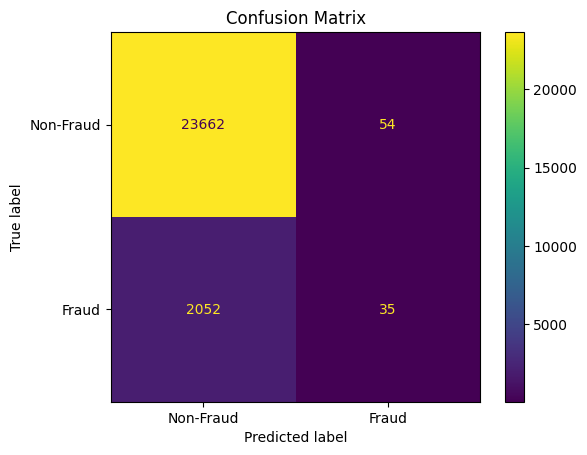

----Summary---
Accuracy: 0.9184
Precision: 0.3933
Recall: 0.0168
F1 Score: 0.0322


In [129]:
predictions, _ = compute_score_for_batch(eidx, X[unique_vertices], y[unique_vertices], batch_size=batch_size)

### Compute Shapley values of different features for a transaction
NOTE: Shapely computation is very expensive

In [130]:
NR_TX =  test_ei.shape[0]//4
batch_size = 1 

transaction_batch = np.random.choice(NR_TX, size=batch_size, replace=False)
idx_of_edges = transaction_batch.reshape(-1, 1) + np.arange(4)*NR_TX

edges_batch = test_ei.iloc[idx_of_edges.ravel()]
unique_vertices, renumbered_edges =  np.unique(edges_batch.values, return_inverse=True)


predictions, shap_values = compute_score_for_batch(renumbered_edges.reshape(edges_batch.shape), X[unique_vertices], y[unique_vertices], batch_size=batch_size, shap=True, feature_mask=feature_mask)

In [131]:
feature_to_attribution_map = dict(zip(feature_mask, shap_values[2]))
feature_name_to_id_map = {v:k for k, v in mask_mapping.items()}

#### Shapley values for different features

In [132]:
{feature_name_to_id_map[k]: f"{v:.3f}" for k, v in feature_to_attribution_map.items()}

{'Card': '0.002',
 'Merchant': '0.013',
 'MCC': '-0.008',
 'Errors': '-0.001',
 'City': '0.003',
 'Zip': '-0.004',
 'Chip': '-0.009',
 'Amount': '0.003'}